# 필요한 모듈을 가져오고 데이터를 로드합니다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'

In [2]:
# FinanceDataReader로 데이터를 불러옵니다
# 예측할 종목은 한양증권(001750) 입니다

import FinanceDataReader as fdr
STOCK_CODE = '001750'

In [3]:
# 기간은 1년으로 잡았습니다

stock = fdr.DataReader(STOCK_CODE, '2020-02-01', '2021-02-01')

Text(0, 0.5, 'price')

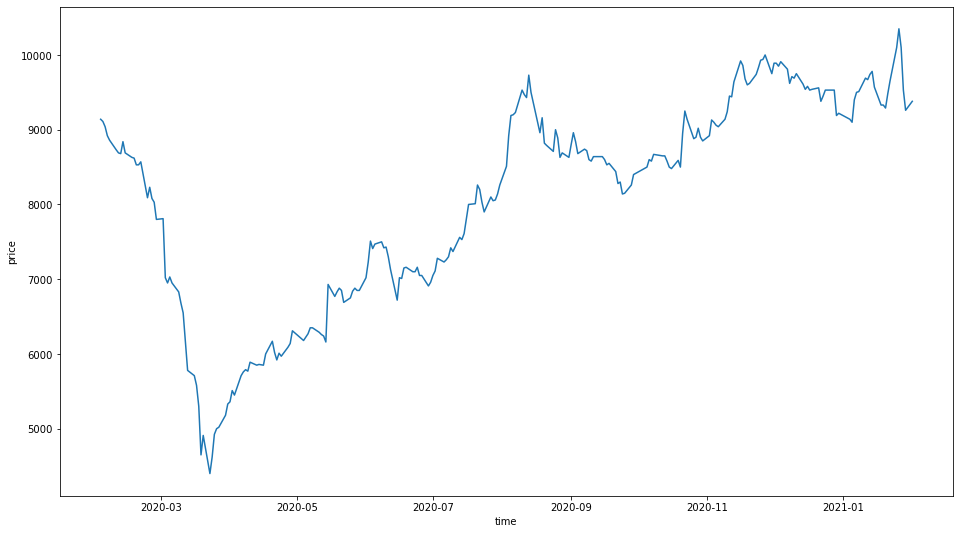

In [4]:
# 학습에 사용될 한양증권 차트입니다

plt.figure(figsize=(16,9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

# Normalization을 진행합니다

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.82537068, 0.80536913, 0.81293706, 0.79663866, 0.03296981],
       [0.77594728, 0.75671141, 0.81118881, 0.79159664, 0.0083776 ],
       [0.78583196, 0.76510067, 0.80769231, 0.77983193, 0.01111828],
       ...,
       [0.90280066, 0.88422819, 0.88811189, 0.86218487, 0.06950447],
       [0.84349259, 0.83221477, 0.83391608, 0.81680672, 0.04761135],
       [0.78583196, 0.81208054, 0.82517483, 0.83697479, 0.02615416]])

In [7]:
df = pd.DataFrame(scaled, columns=scale_cols)

# 데이터를 분할하여 훈련 데이터를 생성합니다

In [8]:
# Train과 Test를 분할합니다

from sklearn.model_selection import train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close',1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [10]:
x_train.shape, y_train.shape

((199, 4), (199,))

In [11]:
x_test.shape, y_test.shape

((50, 4), (50,))

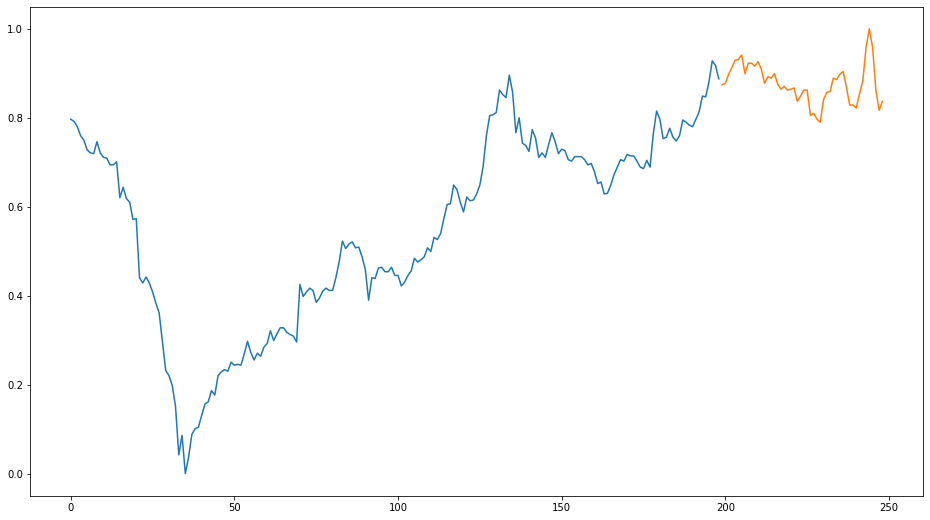

In [12]:
# Train과 Test가 분할된 영역을 차트로 표현했습니다 

plt.figure(figsize=(16,9))
plt.plot(y_train)
plt.plot(y_test)

# 정규화된 훈련 데이터의 평균과 분산을 확인합니다

In [13]:
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std
 
x_test -= mean
x_test /= std

# 딥러닝  네트워크를 학습시킵니다
> 시퀀셜 모델을 활용해서 딥러닝 네트워크를 학습

In [14]:
from keras import models
from keras import layers

def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    # 마지막 레이어는 주택가격인 Y값 1개만 예측하면 되기 때문에 뉴런 수는 1개
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(x_train.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    
    # 손실함수는 mse(예측값과 실제값 사이 거리의 제곱) 이용
    # 모니터링은 mse(예측값과 실제값 사이 거리의 절댓값) 이용
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [15]:
# k-겹 교차 검증 실시
# 현재 10겹이므로 한번 실행마다 50번 반복하고 결국 500번을 훈련하게 된다
# #0의 10개의 mae평균, #1의 10개의 mae평균,,,50번대의 10개의 mae평균,,,이렇게 500개의 mae를 구한다


k = 10
# len(train_data), 404
num_val_samples = len(x_train) // k # 101
num_epochs = 50
all_scores = []

num_epochs = 50
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
 
    # 훈련 데이터 준비: 다른 분할 전체
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
 
    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # model.fit()함수로 회귀 모델을 학습시킨다
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)
 
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3
처리중인 폴드 # 4
처리중인 폴드 # 5
처리중인 폴드 # 6
처리중인 폴드 # 7
처리중인 폴드 # 8
처리중인 폴드 # 9


# Visualize
> 그래프를 보면 앞서 진행했던 LSTM(vr.1)모델 보다 실제 차트와 근사하게 예측 모형이 생성되었음을 알 수 있습니다. 훈련의 횟수가 훨씬 많기 때문이고 중간에 멈추게 하는 요소도 없는 등 훈련 방식에 있어서 차이가 있기 때문입니다. model loss 그래프를 살펴보면 epoch가 증가할수록 model loss가 급격히 줄어드는 경향은 비슷하나 절대적인 loss값 또한 LSTM(vr.2)모델이 우위에 있음을 확인할 수 있습니다 

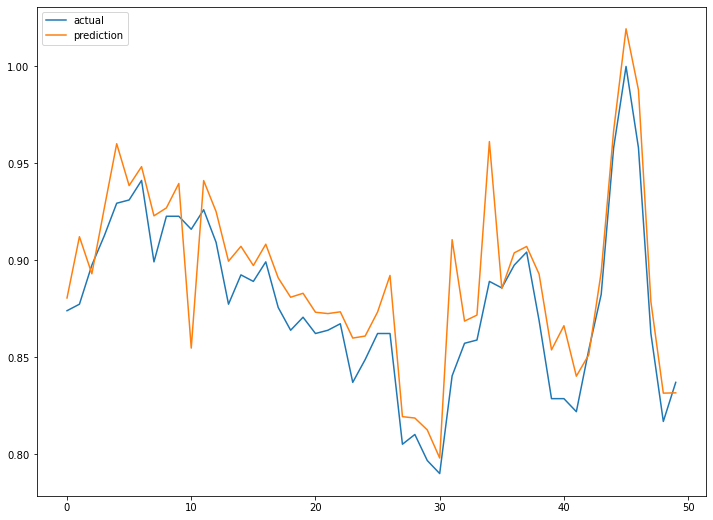

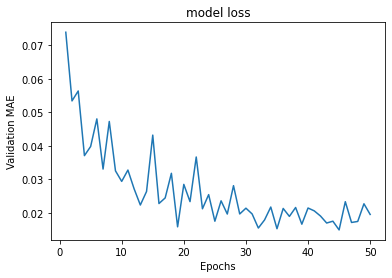

In [16]:
import matplotlib.pyplot as plt

pred = model.predict(x_test)
pred.shape

plt.figure(figsize=(12,9))
plt.plot(np.asarray(y_test), label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.title('model loss')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()